# DELETE ME - DBSCAN Slide Image generators

This week's exercise will focus on density-based clustering using DBSCAN

Schedule:
* Implement the core of DBSCAN
* Clustering visualizations

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
from collections import deque

pd.options.mode.chained_assignment = None

## Take a look at the data

In [3]:
# generate 2d moons dataset
X = np.array([[2., 2.], [5., 2.], [4., 4.], [1., 1.5], [1., 1.], [3., 4.]])
data = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1]))

features = ['x0', 'x1']

data.head(10)

,x0,x1
0,2.0,2.0
1,5.0,2.0
2,4.0,4.0
3,1.0,1.5
4,1.0,1.0
5,3.0,4.0


In [4]:
# Standardize features
# data[features] = data[features].sub(data[features].mean(axis=0)).divide(data[features].std(axis=0))

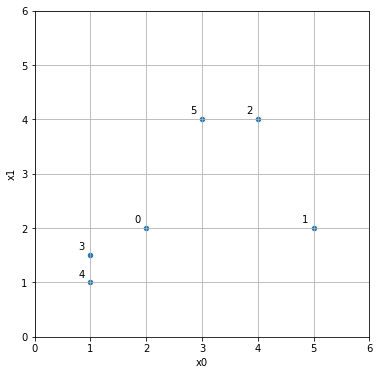

In [5]:
ax = data.plot('x0', 'x1', kind="scatter", figsize=(6,6), grid=True, xlim=(0,6), ylim=(0, 6))
for i, txt in enumerate(data.index):
    ax.annotate(txt, (data.at[i, "x0"] - 0.1,data.at[i, "x1"] + 0.1), size=10, xytext=(0,0), ha='right', textcoords='offset points')

# DBSCAN - TODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODOTODO
[DBSCAN Algorithm](https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d)
1. Initialize the *visited* set and the *toVisitQueue*
2. create K random centroids as arrays with size the number of features
3. foreach `datapoint` in `data`:
  1. set as `centroid` of `datapoint` the closest `centroid`
  2. if at least one `centroid` has changed: goto 3
  
### Tips
- the computations needed for k-means are expensive, test on a small subset of the data to save time (5/10 to check calculations on single rows, 50/100 to check the correctness of the whole algorithm)
- you'll need to compute a distance at a certain point, check Lab3
- [DataFrame.idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html]) will give you the index of the smallest entry in a dataset
- `dataFrame1 is dataFrame2` is not correct (it checks if the two objects are the same, not if they contain the same values). The correct approach is `dataFrame1.equals(dataFrame2)` (or `dataFrame1['aColumn'].equals(dataFrame2['aColumn'])` ;))
- You can apply a function to every element/row/column of a dataframe by using the `apply` pandas function
- To update the values of the centroids, you might find the combination of `groupby` and `mean` to be useful.
### Visualizing DBSCAN Algorithm [(link)](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
Naftali Harris has created a great web-based visualization of running DBSCAN on a 2-dimensional dataset. Try clicking on the “Smiley” dataset and hitting the GO button.

In [6]:
def DBSCAN(data, epsilon=0.25, min_samples=3, max_step=-1):
    
    # 1a - Set of the indices of points that have been already visited
    visited = set()
    
    # 1c - Initialize every point as an outlier (Cluster = -1)
    data = data.assign(Cluster=pd.Series([-1] * len(data)))
    
    currentCluster = 0
    
    currentRow = -1
    
    step = 1
    queue = []
    mex = "Done"
    
    def neighbourhood(x):
        # Find the distance between x and every point in the dataset
        distances = data[features].sub(x[features]) \
            .pow(2).sum(1).pow(0.5)
        # Return the list of indices of the points that are at distance <= epsilon
        ## YOUR CODE HERE
        return distances.loc[(distances <= epsilon)].index.tolist()
    
    # This function starts a cluster formation. 
    # If the starting point is a core point, add its non-visited neighbours to the queue 
    # If the starting point is not a core point, the cluster formation stops and False is returned
    def cluster_formation(startIndex, step_):
        visited.add(startIndex)
        aClusterHasBeenFormed = False
        
        # Queue of the indices of points that are in the neighbourhood of a core point, but that have not been visited yet
        pointsToAddToCurrentCluster = deque()
        pointsToAddToCurrentCluster.append(startIndex)
        if (max_step >= 0 and step_ > max_step):#early stopping
            mex_ = "Point "+str(currentRow)+" has not been visited yet. Start a cluster formation and add point "+str(currentRow)+" to the queue."
            return aClusterHasBeenFormed, step_, pointsToAddToCurrentCluster, mex_
        step_ += 1
        
        # Start the cluster formation: While the queue is not empty...
        while len(pointsToAddToCurrentCluster) > 0:
            # ... Pop from the queue to get the current point
            currentIndex = pointsToAddToCurrentCluster.popleft()
            
            # Get the neighbours of the current point
            ## YOUR CODE HERE
            neighbours = neighbourhood(data.loc[currentIndex])
            
            # If the current point is a core point...
            ## YOUR CODE HERE
            if(len(neighbours) >= min_samples):
                aClusterHasBeenFormed = True
                
                # Assign the current point and its neighbours to the current cluster
                ## YOUR CODE HERE
                data.at[currentIndex, 'Cluster'] = currentCluster
                data.at[neighbours, 'Cluster'] = currentCluster
                
                # Add the non-visited neighbours to the queue of points to visit
                ## YOUR CODE HERE
                for neighbourIndex in neighbours:
                    if not neighbourIndex in visited:
                        visited.add(neighbourIndex)
                        pointsToAddToCurrentCluster.append(neighbourIndex)
                if (max_step >= 0 and step_ > max_step):#early stopping
                    mex_ = "Popped point " + str(currentIndex)+" from the queue. Its neighbourhood is "+ str(neighbours)
                    mex_ += "\n Point "+ str(currentIndex)+" is a core point, so assign its neighbours to the current cluster ("+str(currentCluster)+"), add the unvisited ones to the queue and set them as visited"
                    return aClusterHasBeenFormed, step_, pointsToAddToCurrentCluster, mex_
                step_ += 1
            else:
                if (max_step >= 0 and step_ > max_step):#early stopping
                    mex_ = "Popped point " + str(currentIndex)+" from the queue. Its neighbourhood is "+ str(neighbours)
                    mex_ += "\n Point "+ str(currentIndex)+" is not a core point,  so just continue"
                    return aClusterHasBeenFormed, step_, pointsToAddToCurrentCluster, mex_
                step_ += 1
        if aClusterHasBeenFormed:
            mex_ = "The queue is empty and cluster "+str(currentCluster)+" has been fully formed. CurrentCluster++"
        else:
            mex_ = "The queue is empty and no cluster could be formed. Select the next point from the dataset."
        
        return aClusterHasBeenFormed, step_, pointsToAddToCurrentCluster, mex_
    
    # For each unvisited point in the dataset, start a cluster formation
    for rowIndex in data.index:
        if rowIndex in visited:
            if (max_step >= 0 and step > max_step):#early stopping
                mex = "Point "+str(rowIndex)+" has already been visited -> continue."
                break
            step += 1
            continue
            
        currentRow = rowIndex
        
        aClusterHasBeenFormed, step, queue, mex = cluster_formation(rowIndex, step)
        if (max_step >= 0 and step > max_step):#early stopping
            break
        step += 1
            
        # if a cluster has been formed (= if the current row is not an outlier),
        # increase the currentCluster number for the next iterations
        if aClusterHasBeenFormed:
            currentCluster += 1
    
    if (max_step >= 0 and step > max_step):
        print("Step:", max_step)
    else:
        print("Total steps:", step)
    if(currentRow >=0):
        print("Current Cluster:", str(currentCluster), "(from point "+str(currentRow)+")")
    print("Visited:", visited)
    print("Queue:", list(queue))
    print("What happened:", mex)
    return data

In [7]:
#for i in range(0, 16):
#    print("-----")
#    new_data = DBSCAN(data, epsilon=2, min_samples=2, max_step=i)

In [8]:
new_data = DBSCAN(data, epsilon=2, min_samples=2, max_step=-1)

Total steps: 16
Current Cluster: 2 (from point 2)
Visited: {0, 1, 2, 3, 4, 5}
Queue: []
What happened: The queue is empty and cluster 1 has been fully formed. CurrentCluster++


In [9]:
new_data

,x0,x1,Cluster
0,2.0,2.0,0
1,5.0,2.0,-1
2,4.0,4.0,1
3,1.0,1.5,0
4,1.0,1.0,0
5,3.0,4.0,1


# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

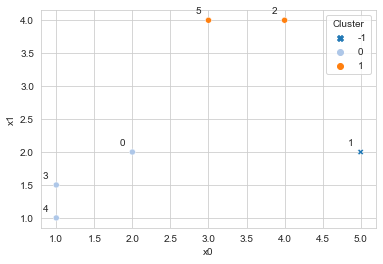

In [10]:
clusterNames = new_data['Cluster'].unique()
clusterNames.sort()
n_clusters = len(clusterNames)

markers_ = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers_[0] = "X"
    
sns.set_style("whitegrid")
ax = sns.scatterplot(data=new_data, x='x0', y='x1', hue='Cluster', palette=sns.color_palette("tab20", n_clusters), style='Cluster', markers=markers_)
for i, txt in enumerate(data.index):
    ax.annotate(txt, (data.at[i, "x0"] - 0.1,data.at[i, "x1"] + 0.1), size=10, xytext=(0,0), ha='right', textcoords='offset points')